In [20]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from google.cloud import bigquery

In [ ]:
dataset = 'your dataset'
tabla = 'your table'

In [21]:
client = bigquery.Client()
table_ref = client.dataset(dataset).table(tabla)
df = client.list_rows(table_ref).to_dataframe()
df.columns = df.columns.str.strip()
df.head()

,postal_code,state_id,county_name,city,lat,lng,ALAND,density,population,count_reviews,avg_annual_payroll_per_employee,avg_rating,n_restaurantes
0,86515,AZ,McKinley,Window Rock,35.70301,-108.99057,14116799310,10.3,3079,79,37305.0,4.063291,2
1,19939,DE,Sussex,Dagsboro,38.56575,-75.20220,2424522544,118.5,7968,18,46303.0,4.777778,1
2,19947,DE,Sussex,Georgetown,38.67421,-75.39864,2424522544,65.2,20128,236,46303.0,4.389831,7
3,19940,DE,Sussex,Delmar,38.47723,-75.56828,2424522544,57.4,6146,20,46303.0,4.100000,2
4,19975,DE,Sussex,Selbyville,38.46862,-75.17462,2424522544,145.3,9610,190,46303.0,4.268421,7


In [22]:
df['avg_annual_payroll_per_employee'] = df['avg_annual_payroll_per_employee'].astype(float)
df['density'] = df['density'].astype(float)
df.dropna(subset=['avg_annual_payroll_per_employee', 'density', 'count_reviews', 'n_restaurantes'], inplace=True)

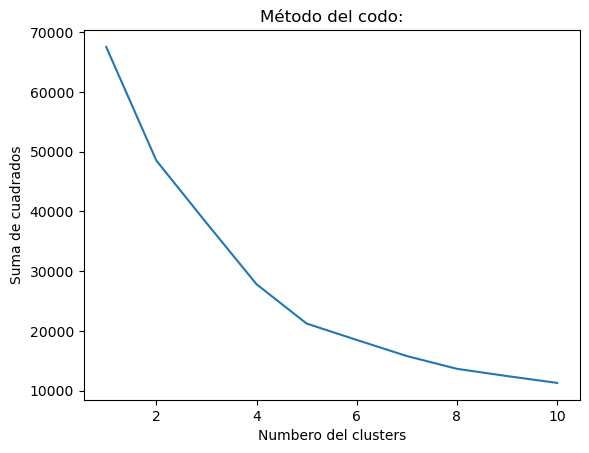

In [23]:
selected_features = df[['avg_annual_payroll_per_employee', 'density', 'count_reviews', 'n_restaurantes']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

wcss = [] 
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Método del codo:')
plt.xlabel('Numbero del clusters')
plt.ylabel('Suma de cuadrados')  
plt.show()


In [24]:
n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(scaled_features)

df['cluster'] = kmeans.labels_

mediana_cluster = df.groupby('cluster').median()
cluster_conteo = df['cluster'].value_counts()
cluster_statistics = pd.concat([medias_del_cluster, cluster_conteo], axis=1)

print(cluster_statistics[['density', 'count_reviews','avg_annual_payroll_per_employee', 'n_restaurantes', 'cluster']])

    density  count_reviews  avg_annual_payroll_per_employee  n_restaurantes  \
0     36.60           85.0                          45617.0             3.0   
1  23740.90         1182.0                          77709.0            33.0   
2   1229.60         3495.0                          62556.0            94.0   
3   1086.70          310.0                          66074.0             8.0   
4   6536.65        41227.5                          68742.0           497.0   
5   1520.30        13477.0                          64102.0           199.0   

   cluster  
0    12405  
1      109  
2      303  
3     4007  
4        6  
5       51  


In [25]:
columnas_buenas = ['density', 'avg_annual_payroll_per_employee']
columnas_malas  = ['count_reviews', 'n_restaurantes']
mediana_cluster[columnas_buenas] = df[columnas_buenas].rank(ascending=True)
mediana_cluster[columnas_malas] = df[columnas_malas].rank(ascending=False)
mediana_cluster['RangoTotal'] = df[columnas_buenas + columnas_malas].sum(axis=1)
mediana_cluster = mediana_cluster.sort_values(by='RangoTotal')
mediana_cluster

,lat,lng,ALAND,density,population,count_reviews,avg_annual_payroll_per_employee,avg_rating,n_restaurantes,RangoTotal
cluster,,,,,,,,,,
0,39.95050,-86.93988,1703659884.0,2804.0,5514.0,10165.0,1229.5,4.363636,11386.5,37396.3
5,36.16789,-86.15703,1026465038.0,6606.0,24948.0,16174.5,6647.0,3.986540,14706.0,46353.1
3,40.65238,-81.79246,1503973504.0,7740.0,21068.0,14780.0,6647.0,4.262626,11386.5,46382.4
1,40.75856,-73.95392,108910661.0,9391.5,51303.0,15075.5,6647.0,4.244503,14706.0,46440.5
2,39.68985,-82.67753,1114851817.0,8056.5,33490.0,5940.5,6647.0,3.866352,5473.0,46611.2
4,39.71514,-80.98186,393166820.0,9828.0,21734.0,6762.0,6647.0,4.006964,5473.0,46645.3


In [26]:
mapa_cluster = {
    0: 'A',
    1: 'D',
    2: 'E',
    3: 'C',
    4: 'F',
    5: 'B'
}

In [27]:
df['oportunidad'] = df['cluster'].replace(mapa_cluster)


In [38]:
df_opor = df[['postal_code','state_id', 'oportunidad']]

In [40]:
df_opor.to_csv('oportunidad_por_postal.csv')